# Learning rate and evaluation - Eager execution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.6.0


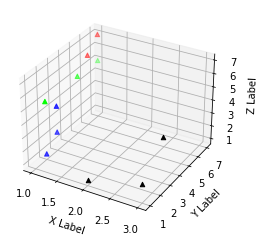

In [2]:
x_train = [[1, 2, 1],
          [1, 3, 2],
          [1, 3, 4],
          [1, 5, 5],
          [1, 7, 5],
          [1, 2, 5],
          [1, 6, 6],
          [1, 7, 7]]

y_train = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1],
          [0, 1, 0],
          [0, 1, 0],
          [0, 1, 0],
          [1, 0, 0],
          [1, 0, 0]]

# Evaluation our model using this test dataset
x_test = [[2, 1, 1],
          [3, 1, 2],
          [3, 3, 4]]
y_test = [[0, 0, 1],
          [0, 0, 1],
          [0, 0, 1]]


x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]
x3 = [x[2] for x in x_train]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3, c=y_train, marker='^')

ax.scatter(x_test[0][0], x_test[0][1], x_test[0][2], c="black", marker='^')
ax.scatter(x_test[1][0], x_test[1][1], x_test[1][2], c="black", marker='^')
ax.scatter(x_test[2][0], x_test[2][1], x_test[2][2], c="black", marker='^')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Tensorflow Eager

- Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
- features,labels는 실재 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))#.repeat()

In [5]:
W = tf.Variable(tf.random.normal((3, 3)))
b = tf.Variable(tf.random.normal((3,)))

In [6]:
def softmax_fn(features):
    hypothesis = tf.nn.softmax(tf.matmul(features, W) + b)
    return hypothesis

def loss_fn(hypothesis, features, labels):
    cost = tf.reduce_mean(-tf.reduce_sum(labels * tf.math.log(hypothesis), axis=1))
    return cost

## Learning Rate 값을 조정하기 위한 Learning Decay 설정
5개 파라미터 설정
- starter_learning_rate : 최초 학습시 사용될 learning rate (0.1로 설정하여 0.96씩 감소하는지 확인)
- global_step : 현재 학습 횟수
- 1000 : 곱할 횟수 정의 (1000번에 마다 적용)
- 0.96 : 기존 learning에 곱할 값
- 적용유무 decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

In [7]:
is_decay = True
starter_learning_rate = 0.1
    
if(is_decay):    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                 decay_steps=1000,
                                                                 decay_rate=0.96,
                                                                 staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(softmax_fn(features),features,labels)
    return tape.gradient(loss_value, [W,b])

In [8]:
def accuracy_fn(hypothesis, labels):
    prediction = tf.argmax(hypothesis, 1)
    is_correct = tf.equal(prediction, tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
    return accuracy

In [9]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in iter(dataset):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads = grad(softmax_fn(features), features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(softmax_fn(features),features,labels)))
x_test = tf.cast(x_test, tf.float32)
y_test = tf.cast(y_test, tf.float32)
test_acc = accuracy_fn(softmax_fn(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 7.8510
Iter: 100, Loss: 0.6915
Iter: 200, Loss: 0.5892
Iter: 300, Loss: 0.5326
Iter: 400, Loss: 0.4927
Iter: 500, Loss: 0.4615
Iter: 600, Loss: 0.4358
Iter: 700, Loss: 0.4139
Iter: 800, Loss: 0.3951
Iter: 900, Loss: 0.3785
Iter: 1000, Loss: 0.3638
Testset Accuracy: 1.0000


# linear regression(without min/max)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.6.0


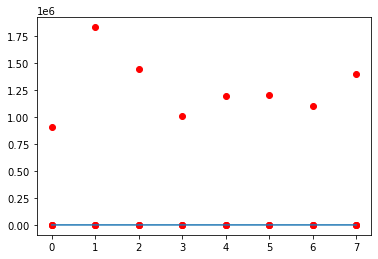

In [11]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [13]:
W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

In [14]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

def loss_fn(hypothesis, features, labels):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    return cost

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features),features,labels)
    return tape.gradient(loss_value, [W,b]), loss_value

In [16]:
EPOCHS = 101

for step in range(EPOCHS):
    for features, labels  in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        hypo_value = linearReg_fn(features)
        grads, loss_value = grad(linearReg_fn(features), features, labels)        
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))    
    print("Iter: {}, Loss: {:.4f}, Prediction: {}".format(step, loss_value, hypo_value))

Iter: 0, Loss: 5136834560.0000, Prediction: [[ -49687.156]
 [-100995.7  ]
 [ -79251.805]
 [ -55277.945]
 [ -65311.965]
 [ -65869.88 ]
 [ -60302.1  ]
 [ -77032.25 ]]
Iter: 1, Loss: 5643738691255766863577088.0000, Prediction: [[1.6757714e+12]
 [3.3734997e+12]
 [2.6538103e+12]
 [1.8603069e+12]
 [2.1924711e+12]
 [2.2109249e+12]
 [2.0263890e+12]
 [2.5799961e+12]]
Iter: 2, Loss: inf, Prediction: [[-5.5545705e+19]
 [-1.1181921e+20]
 [-8.7964132e+19]
 [-6.1662389e+19]
 [-7.2672419e+19]
 [-7.3284086e+19]
 [-6.7167402e+19]
 [-8.5517455e+19]]
Iter: 3, Loss: inf, Prediction: [[1.8411374e+27]
 [3.7063983e+27]
 [2.9156897e+27]
 [2.0438832e+27]
 [2.4088256e+27]
 [2.4291002e+27]
 [2.2263544e+27]
 [2.8345916e+27]]
Iter: 4, Loss: inf, Prediction: [[-6.1026988e+34]
 [-1.2285358e+35]
 [-9.6644474e+34]
 [-6.7747269e+34]
 [-7.9843775e+34]
 [-8.0515803e+34]
 [-7.3795522e+34]
 [-9.3956361e+34]]
Iter: 5, Loss: inf, Prediction: [[inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]
 [inf]]
Iter: 6, Loss: nan, Predict

# linear regression - Eager (normalization, decay, l2_loss)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility

print(tf.__version__)

2.6.0


In [18]:
def normalization(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / denominator

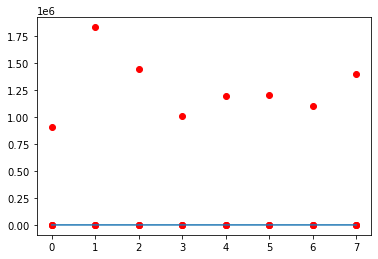

In [19]:
xy = np.array([[828.659973, 833.450012, 908100, 828.349976, 831.659973],
               [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
               [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
               [816, 820.958984, 1008100, 815.48999, 819.23999],
               [819.359985, 823, 1188100, 818.469971, 818.97998],
               [819, 823, 1198100, 816, 820.450012],
               [811.700012, 815.25, 1098100, 809.780029, 813.669983],
               [809.51001, 816.659973, 1398100, 804.539978, 809.559998]])

x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)
plt.show()

[[1.         1.         0.         1.         1.        ]
 [0.70548491 0.70439552 1.         0.71881783 0.83755792]
 [0.54412549 0.50274824 0.57608696 0.60646801 0.6606331 ]
 [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
 [0.51436    0.4258239  0.30434783 0.58504805 0.42624401]
 [0.49556179 0.4258239  0.31521739 0.48131134 0.49276137]
 [0.11436064 0.         0.20652174 0.22007776 0.18597238]
 [0.         0.07747099 0.5326087  0.         0.        ]]


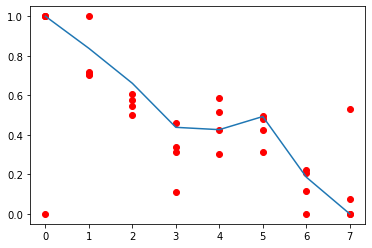

In [20]:
xy = normalization(xy)
print(xy)
x_train = xy[:, 0:-1]
y_train = xy[:, [-1]]

plt.plot(x_train, 'ro')
plt.plot(y_train)

plt.show()

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [22]:
W = tf.Variable(tf.random.normal((4, 1)), dtype=tf.float32)
b = tf.Variable(tf.random.normal((1,)), dtype=tf.float32)

In [23]:
def linearReg_fn(features):
    hypothesis = tf.matmul(features, W) + b
    return hypothesis

# Weight의 수가 많아지면 수만큼 더한다 tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)
def l2_loss(loss, beta = 0.01):
    W_reg = tf.nn.l2_loss(W) # output = sum(t ** 2) / 2
    loss = tf.reduce_mean(loss + W_reg * beta)
    return loss

In [24]:
def loss_fn(hypothesis, features, labels, flag = False):
    cost = tf.reduce_mean(tf.square(hypothesis - labels))
    if(flag):
        cost = l2_loss(cost)
    return cost

In [25]:
is_decay = True
starter_learning_rate = 0.1

if(is_decay):    
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=starter_learning_rate,
                                                                  decay_steps=50,
                                                                  decay_rate=0.96,
                                                                  staircase=True)
    optimizer = tf.keras.optimizers.SGD(learning_rate)
else:
    optimizer = tf.keras.optimizers.SGD(learning_rate=starter_learning_rate)

def grad(hypothesis, features, labels, l2_flag):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(linearReg_fn(features),features,labels, l2_flag)
    return tape.gradient(loss_value, [W,b]), loss_value

In [26]:
EPOCHS = 101

for step in range(EPOCHS):
    for features, labels  in dataset:
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        grads, loss_value = grad(linearReg_fn(features), features, labels, False)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))        
    if step % 10 == 0:
        print("Iter: {}, Loss: {:.4f}".format(step, loss_value))

Iter: 0, Loss: 1.7346
Iter: 10, Loss: 0.0745
Iter: 20, Loss: 0.0438
Iter: 30, Loss: 0.0273
Iter: 40, Loss: 0.0181
Iter: 50, Loss: 0.0128
Iter: 60, Loss: 0.0099
Iter: 70, Loss: 0.0080
Iter: 80, Loss: 0.0068
Iter: 90, Loss: 0.0060
Iter: 100, Loss: 0.0054
